In [1]:
import collections
import numpy as np
import os
import pandas as pd
import tqdm.auto as tqdm
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '0.data_preparation')))
import utils

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "test_data"
method = "phm"

# Specify CM method parameters
# VCMtools
vcm_window = "0.5Mb"
pv_threshold = "0.001"
# Clomics
n_peaks = "n_peaks_200"
bg_threshold = "bg_threshold_3"
# PHM
pp_threshold = 0.8

# to use TAD and AB compartment information, set use_tad_ab_info = True
# Make sure to prepare the data in the correct format!
# (see Jupyter notebooks in Chromatin_modules/genome_annotations/TADs_AB_compartments)
use_tad_ab_info = False
folder_name = "no_TADs_no_AB_compartments"

# Specify simulation parameters
n_closest_cms = 5
k_sim_per_cm = 10

save_files = True

In [3]:
# Specify QC parameters
pct_adjust = True
pct = 0.2  # for CM lengths; 0.5 for total CM peak length in bp

In [4]:
core_path = "/data/pushkare/Chromatin_modules/3.simulate_CMs"
count_mtx_path = "/data/pushkare/Chromatin_modules/test_data"
sim_cm_path = os.path.join(core_path, "output", folder_name)

filter_type = "stringent_filtering_by_length"
path_to_data_output = os.path.join(
    core_path, "output", folder_name, "QC", filter_type, method
)
if not os.path.exists(path_to_data_output):
    os.makedirs(path_to_data_output)

path_to_plots = os.path.join(
    core_path, "output", folder_name, "QC", "plots", filter_type
)
if not os.path.exists(path_to_plots):
    os.makedirs(path_to_plots)

In [5]:
sim_tracks_df, sim_w_chr_dict, sim_ref_cm_set = utils.get_dict_with_cm_tracks_df(
    sim_cm_path, method, dataset, "sim", use_tad_ab_info=use_tad_ab_info
)
cm_tracks_df, cm_w_chr_dict = utils.get_dict_with_cm_tracks_df(
    sim_cm_path, method, dataset, "ref", sim_ref_cm_set, use_tad_ab_info=use_tad_ab_info
)

In [6]:
sim_content_df = utils.get_cm_content_df(sim_cm_path, method, dataset, "sim")
cm_content_df = utils.get_cm_content_df(sim_cm_path, method, dataset, "ref")

In [7]:
if len(set(sim_tracks_df["ref_cm_id"])) == cm_tracks_df.shape[0]:
    print("Shapes for simulated and reference CMs", dataset, "are ok")
else:
    print(
        "Warning: Shapes for simulated and reference CMs",
        dataset,
        "are not ok!\n Check filtering steps",
    )

Shapes for simulated and reference CMs test_data are ok


In [8]:
ref_content_df = cm_content_df.copy()
sim_content_df = sim_content_df.copy()

sim_tracks_df = sim_tracks_df.copy()
sim_tracks_df.loc[:, "sim_cm_length"] = (
    sim_tracks_df.loc[:, "end"] - sim_tracks_df.loc[:, "start"]
)

ref_tracks_df = cm_tracks_df.copy()
ref_tracks_df.columns = "ref_" + ref_tracks_df.columns
ref_tracks_df.loc[:, "ref_cm_length"] = (
    ref_tracks_df.loc[:, "ref_end"] - ref_tracks_df.loc[:, "ref_start"]
)

merged_tracks_df = sim_tracks_df.merge(ref_tracks_df, on="ref_cm_id")

### Filter by bp length
merged_tracks_df.loc[:, "sim_peak_bp_length"] = [
    np.sum([int(sim_peak_length) for sim_peak_length in sim_p_lengths])
    for sim_p_lengths in merged_tracks_df.loc[:, "peak_length"].str.split(",").tolist()
]
merged_tracks_df.loc[:, "ref_peak_bp_length"] = [
    np.sum([int(ref_peak_length) for ref_peak_length in ref_p_lengths])
    for ref_p_lengths in merged_tracks_df.loc[:, "ref_peak_length"]
    .str.split(",")
    .tolist()
]

id_lengths = np.arange(
    0,
    merged_tracks_df.loc[:, ["ref_cm_length", "sim_cm_length"]].max(axis=1).max() + 1,
)
if pct_adjust:
    valid_range_dict_len = dict(
        zip(
            id_lengths,
            list(zip(id_lengths - id_lengths * pct, id_lengths + id_lengths * pct)),
        )
    )
    valid_range_dict_bp = dict(
        zip(
            id_lengths,
            list(zip(id_lengths - id_lengths * 0.5, id_lengths + id_lengths * 0.5)),
        )
    )
else:
    length_gap = 5000
    valid_range_dict = dict(
        zip(id_lengths, list(zip(id_lengths - length_gap, id_lengths + length_gap)))
    )

sim_cms_to_subset_len = set()
sim_cms_to_subset_bp = set()
counter = 0
for row_idx, row in merged_tracks_df.iterrows():
    ref_len, sim_len = row["ref_cm_length"], row["sim_cm_length"]
    ref_boundaries_len = valid_range_dict_len.get(ref_len)
    sim_boundaries_len = valid_range_dict_len.get(sim_len)
    if utils.check_boundaries(ref_len, sim_len, ref_boundaries_len, sim_boundaries_len):
        sim_cms_to_subset_len.update([row["sim_cm_id"]])

    ref_bp, sim_bp = row["ref_peak_bp_length"], row["sim_peak_bp_length"]
    ref_boundaries_bp = valid_range_dict_bp.get(ref_bp)
    sim_boundaries_bp = valid_range_dict_bp.get(sim_bp)
    if utils.check_boundaries(ref_bp, sim_bp, ref_boundaries_bp, sim_boundaries_bp):
        sim_cms_to_subset_bp.update([row["sim_cm_id"]])
    else:
        counter += 1
sim_cms_to_subset = sim_cms_to_subset_bp.intersection(sim_cms_to_subset_len)

length_filtered_sim_tracks_df = sim_tracks_df.loc[
    sim_tracks_df.loc[:, "sim_cm_id"].isin(sim_cms_to_subset), :
]

length_filtered_ref_tracks_df = ref_tracks_df.loc[
    ref_tracks_df.loc[:, "ref_cm_id"].isin(
        set(length_filtered_sim_tracks_df.loc[:, "ref_cm_id"])
    ),
    :,
]

if not length_filtered_ref_tracks_df.shape[0] == len(
    set(length_filtered_sim_tracks_df.loc[:, "ref_cm_id"])
):
    print("Number of simulated cms is incorrect!")
    sys.exit()

length_filtered_ref_content_df = ref_content_df.loc[
    ref_content_df.loc[:, "cm_id"].isin(
        length_filtered_ref_tracks_df.loc[:, "ref_cm_id"]
    ),
    :,
]

length_filtered_sim_content_df = sim_content_df.loc[
    sim_content_df.loc[:, "cm_id"].isin(length_filtered_sim_tracks_df.loc[:, "cm_id"]),
    :,
]

if (
    not length_filtered_ref_content_df.shape[0]
    == length_filtered_ref_tracks_df.shape[0]
):
    print("Number of Reference cms in .content and .tracks is different!")
    sys.exit()

if (
    not length_filtered_sim_content_df.shape[0]
    == length_filtered_sim_tracks_df.shape[0]
):
    print("Number of Simulated cms in .content and .tracks is different!")
    sys.exit()

if save_files:
    # Save reference cms
    length_filtered_ref_tracks_df.to_csv(
        os.path.join(
            path_to_data_output,
            "_".join(
                [
                    dataset,
                    "ref",
                    method,
                    "length_filtering.tracks.bed",
                ]
            ),
        ),
        sep="\t",
        index=False,
        header=False,
    )
    length_filtered_ref_content_df.to_csv(
        os.path.join(
            path_to_data_output,
            "_".join(
                [
                    dataset,
                    "ref",
                    method,
                    "length_filtering.content.txt",
                ]
            ),
        ),
        sep="\t",
        index=False,
        header=False,
    )

    # Save simulated cms
    length_filtered_sim_tracks_df.to_csv(
        os.path.join(
            path_to_data_output,
            "_".join(
                [
                    dataset,
                    "sim",
                    method,
                    "length_filtering.tracks.bed",
                ]
            ),
        ),
        sep="\t",
        index=False,
        header=False,
    )
    length_filtered_sim_content_df.to_csv(
        os.path.join(
            path_to_data_output,
            "_".join(
                [
                    dataset,
                    "sim",
                    method,
                    "length_filtering.content.txt",
                ]
            ),
        ),
        sep="\t",
        index=False,
        header=False,
    )

#### Get ref and sim stats

In [9]:
simulation_types = {
    "all_simulated_cms": "",
    "stringent_filtering_by_length": "_length_filtering",
}
dict_with_ref_sim_cm_paths = {}
for simulation_type, extension in simulation_types.items():
    if simulation_type == "all_simulated_cms":
        path = os.path.join(sim_cm_path, method, simulation_type)
        suffix = "_no_repeating_peaks_matched"
        extension = ""
    else:
        path = path_to_data_output
        suffix = ""
    dict_with_ref_sim_cm_paths[simulation_type] = {
        "reference": os.path.join(
            path,
            dataset + "_ref_" + method + suffix + extension,
        ),
        "simulated": os.path.join(
            path,
            dataset + "_sim_" + method + suffix + extension,
        ),
    }

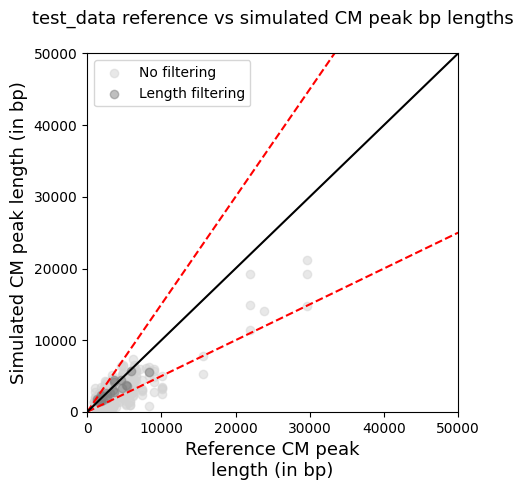

In [10]:
all_cms_merged = utils.get_merged_ref_sim(
    dict_with_ref_sim_cm_paths,
    "all_simulated_cms",
    use_tad_ab_info=use_tad_ab_info,
)
length_cms_merged = utils.get_merged_ref_sim(
    dict_with_ref_sim_cm_paths,
    "stringent_filtering_by_length",
    use_tad_ab_info=use_tad_ab_info,
)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
ax.scatter(
    all_cms_merged["ref_peak_bp_length"],
    all_cms_merged["sim_peak_bp_length"],
    alpha=0.5,
    color="lightgray",
    label="No filtering",
    rasterized=True,
)
ax.scatter(
    length_cms_merged["ref_peak_bp_length"],
    length_cms_merged["sim_peak_bp_length"],
    alpha=0.5,
    color="gray",
    label="Length filtering",
    rasterized=True,
)
ax.set_xlabel("Reference CM peak\nlength (in bp)", size=13)
ax.set_ylabel("Simulated CM peak length (in bp)", size=13)
ax.set_title(dataset + " reference vs simulated CM peak bp lengths\n", size=13)
id_lengths = np.arange(0, 50000)
#     for plot_idx in [0, 1]:
ax.set_xlim((0, 50000))
ax.set_ylim((0, 50000))
ax.legend()
if pct_adjust:
    ax.plot(id_lengths, id_lengths - id_lengths * 0.5, "--", color="red")
    ax.plot(id_lengths, id_lengths + id_lengths * 0.5, "--", color="red")
else:
    ax.plot(id_lengths, id_lengths - length_gap, "--", color="red")
    ax.plot(id_lengths, id_lengths + length_gap, "--", color="red")
ax.plot(id_lengths, id_lengths, "-", color="black")

plt.tight_layout()
plt.savefig(
    os.path.join(
        path_to_plots,
        "_".join([dataset, method, "reference_vs_simulated_peak_bp_lengths.pdf"]),
    ),
    bbox_inches="tight",
    edgecolor=None,
    facecolor=None,
    transparent=True,
    dpi=300,
)

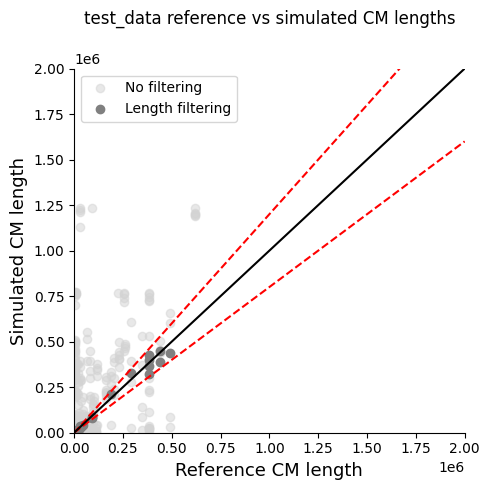

In [11]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(5, 5),
    #         sharey=True
)
ax.scatter(
    all_cms_merged["ref_length"],
    all_cms_merged["sim_length"],
    alpha=0.5,
    color="lightgray",
    label="No filtering",
    rasterized=True,
)
ax.scatter(
    length_cms_merged["ref_length"],
    length_cms_merged["sim_length"],
    alpha=1,
    color="gray",
    label="Length filtering",
    rasterized=True,
)
ax.set_xlabel("Reference CM length", size=13)
ax.set_ylabel("Simulated CM length", size=13)
ax.set_title(dataset + " reference vs simulated CM lengths\n", size=12)
id_lengths = np.arange(0, 2 * 10**6)
#     for plot_idx in [0, 1]:
ax.set_xlim((0, 2 * 10**6))
ax.set_ylim((0, 2 * 10**6))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend()
if pct_adjust:
    ax.plot(id_lengths, id_lengths - id_lengths * pct, "--", color="red")
    ax.plot(id_lengths, id_lengths + id_lengths * pct, "--", color="red")
else:
    ax.plot(id_lengths, id_lengths - length_gap, "--", color="red")
    ax.plot(id_lengths, id_lengths + length_gap, "--", color="red")
ax.plot(id_lengths, id_lengths, "-", color="black")

plt.tight_layout()
plt.savefig(
    os.path.join(
        path_to_plots,
        "_".join([dataset, method, "reference_vs_simulated_CM_lengths.pdf"]),
    ),
    bbox_inches="tight",
    edgecolor=None,
    facecolor=None,
    transparent=True,
    dpi=100,
)

### Filter CMs by GC content

In [12]:
simulation_type = "stringent_filtering_by_length"
extension = "length_filtering"

In [13]:
gc_content_all_peaks = np.load(
    "/data/pushkare/Chromatin_modules/genome_annotations/GC_content/k27ac_k4me1_peaks_GC_content.npy",
    allow_pickle=True,
).item()

In [14]:
window = 0.1

In [15]:
ref_sim_content_dict = dict_with_ref_sim_cm_paths.get(simulation_type)
content_ref_cms_df = pd.read_csv(
    ref_sim_content_dict.get("reference") + ".content.txt", sep="\t", header=None
)
content_sim_cms_df = pd.read_csv(
    ref_sim_content_dict.get("simulated") + ".content.txt", sep="\t", header=None
)
if not "chr" in content_ref_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_ref_cms_df.iloc[:, 2] = content_ref_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )
if not "chr" in content_sim_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_sim_cms_df.iloc[:, 2] = content_sim_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )

ref_cm_peaks_dict = dict(
    zip(content_ref_cms_df.iloc[:, 0], content_ref_cms_df.iloc[:, 2].str.split(","))
)
sim_cm_peaks_dict = dict(
    zip(content_sim_cms_df.iloc[:, 0], content_sim_cms_df.iloc[:, 2].str.split(","))
)

ref_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=ref_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)
sim_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=sim_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)

tracks_sim_cms_df = pd.read_csv(
    ref_sim_content_dict.get("simulated") + ".tracks.bed", sep="\t", header=None
)

ref_sim_cm_id_mapping = {
    ref_cm: sim_df_for_ref.iloc[:, 3].to_list()
    for ref_cm, sim_df_for_ref in tracks_sim_cms_df.groupby(13)
    if sim_df_for_ref.shape[0]
}

ref_gc, sim_gc = [], []
for ref_cm, sim_cm_ids in ref_sim_cm_id_mapping.items():
    ref_cm_id_gc = ref_gc_content.get(ref_cm, "NAN")
    if ref_cm_id_gc == "NAN":
        continue
    list_with_sim_ids = []
    for sim_cm_id in sim_cm_ids:
        if sim_gc_content.get(sim_cm_id, "NAN") != "NAN":
            left_b, right_b = ref_cm_id_gc - window, ref_cm_id_gc + window
            if left_b < sim_gc_content.get(sim_cm_id, "NAN") < right_b:
                list_with_sim_ids.append(sim_cm_id)
    if list_with_sim_ids == []:
        continue
    ref_gc.append(ref_cm)
    sim_gc.extend(list_with_sim_ids)

In [16]:
ref_content = pd.read_csv(
    ref_sim_content_dict.get("reference") + ".content.txt", sep="\t", header=None
)
ref_tracks = pd.read_csv(
    ref_sim_content_dict.get("reference") + ".tracks.bed", sep="\t", header=None
)

sim_content = pd.read_csv(
    ref_sim_content_dict.get("simulated") + ".content.txt", sep="\t", header=None
)
sim_tracks = pd.read_csv(
    ref_sim_content_dict.get("simulated") + ".tracks.bed", sep="\t", header=None
)
_output_path = os.path.join(
    core_path,
    "output",
    folder_name,
    "QC",
    "stringent_filtering_by_length_and_gc_content",
    method,
)
if not os.path.exists(_output_path):
    os.makedirs(_output_path)
utils.subset_tracks_content(
    ref_tracks,
    ref_content,
    cms_to_subset=ref_gc,
    save_files=True,
    output_path=_output_path,
    output_file_name="_".join(
        [
            dataset,
            "ref",
            method,
            "length",
            "GC_content_filtering",
        ]
    ),
)
utils.subset_tracks_content(
    sim_tracks,
    sim_content,
    cms_to_subset=sim_gc,
    save_files=True,
    output_path=_output_path,
    output_file_name="_".join(
        [
            dataset,
            "sim",
            method,
            "length",
            "GC_content_filtering",
        ]
    ),
)

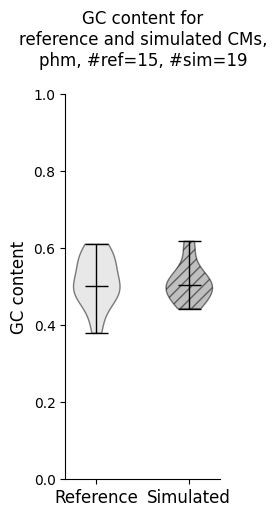

In [17]:
content_ref_cms_df = pd.read_csv(
    ref_sim_content_dict.get("reference") + ".content.txt", sep="\t", header=None
)
content_sim_cms_df = pd.read_csv(
    ref_sim_content_dict.get("simulated") + ".content.txt", sep="\t", header=None
)

if not "chr" in content_ref_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_ref_cms_df.iloc[:, 2] = content_ref_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )
if not "chr" in content_sim_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_sim_cms_df.iloc[:, 2] = content_sim_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )

ref_cm_peaks_dict = dict(
    zip(content_ref_cms_df.iloc[:, 0], content_ref_cms_df.iloc[:, 2].str.split(","))
)
sim_cm_peaks_dict = dict(
    zip(content_sim_cms_df.iloc[:, 0], content_sim_cms_df.iloc[:, 2].str.split(","))
)

ref_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=ref_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)
sim_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=sim_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)

tracks_sim_cms_df = pd.read_csv(
    ref_sim_content_dict["simulated"] + ".tracks.bed", sep="\t", header=None
)

ref_sim_cm_id_mapping = {
    ref_cm: sim_df_for_ref.iloc[:, 3].to_list()
    for ref_cm, sim_df_for_ref in tracks_sim_cms_df.groupby(13)
    if sim_df_for_ref.shape[0]
}

ref_gc, sim_gc = [], []
for ref_cm, sim_cm_ids in ref_sim_cm_id_mapping.items():
    ref_cm_id_gc = ref_gc_content.get(ref_cm, "NAN")
    if ref_cm_id_gc == "NAN":
        continue
    lst_for_avg = []
    for sim_cm_id in sim_cm_ids:
        if sim_gc_content.get(sim_cm_id, "NAN") != "NAN":
            left_b, right_b = ref_cm_id_gc - window, ref_cm_id_gc + window
            if left_b < sim_gc_content.get(sim_cm_id, "NAN") < right_b:
                lst_for_avg.append(sim_gc_content.get(sim_cm_id))
    if lst_for_avg == []:
        continue
    sim_gc.extend(lst_for_avg)
    ref_gc.append(ref_cm_id_gc)

fig, ax = plt.subplots(figsize=(2, 5))
violin_plot = ax.violinplot([ref_gc, sim_gc], [1.2, 1.5], widths=0.15, showmedians=True)
_, ref_sim_pv = scipy.stats.mannwhitneyu(
    ref_gc,
    sim_gc,
)
if ref_sim_pv <= 0.05:
    if ref_sim_pv <= 0.001:
        annot_star = "***"
    elif (ref_sim_pv > 0.001) and (ref_sim_pv <= 0.01):
        annot_star = "**"
    elif (ref_sim_pv > 0.01) and (ref_sim_pv <= 0.05):
        annot_star = "*"
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transData)
    ax.annotate(
        annot_star,
        xy=(1.35, 0.85),
        xytext=(1.35, 0.85),
        transform=trans,
        ha="center",
        va="bottom",
        arrowprops=dict(arrowstyle="-[, widthB=3, lengthB=0.5", lw=1),
    )
colors = ["lightgray", "gray"]

for i, vp in enumerate(violin_plot["bodies"]):
    vp.set_facecolor(colors[i])
    vp.set_edgecolor("black")
    if i % 2 == 0:
        vp.set(linewidth=1, alpha=0.5)
    else:
        vp.set(
            linewidth=1,
            alpha=0.5,
            hatch="///",
        )

for vp_stat in ["cbars", "cmins", "cmaxes", "cmedians"]:
    vp = violin_plot[vp_stat]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1.2, 1.5])
ax.set_xticklabels(["Reference", "Simulated"], size=12)
ax.set_ylabel("GC content", size=12)
ax.set_title(
    "\n".join(
        [
            "GC content for",
            "reference and simulated CMs,",
            method + ", #ref=" + str(len(ref_gc)) + ", #sim=" + str(len(sim_gc)),
            "",
        ]
    ),
    size=12,
)
ax.set_ylim((0, 1))
ax.set_xlim((1.1, 1.6))
plt.savefig(
    os.path.join(
        _output_path,
        dataset + "_violinplot_ref_sim_CMs_GC_content_mannwhitneyu_pv_0.01.pdf",
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

### Filter by H3K27ac contribution to CM composition

In [18]:
simulation_type = "stringent_filtering_by_length_and_gc_content"
extension = "length_GC_content_filtering"

path_to_output = os.path.join(
    "/data/pushkare/Chromatin_modules/3.simulate_CMs/output/", folder_name, "QC"
)

In [19]:
dataset_mark_counter_dict = {}
k27ac_filtered_ref_cm_ids_per_ds = {}
k27ac_filtered_sim_cm_ids_per_ds = {}
content_sim_cms_path = os.path.join(
    path_to_output,
    simulation_type,
    method,
    "_".join([dataset, "sim", method, extension + ".content.txt"]),
)
content_ref_cms_path = os.path.join(
    path_to_output,
    simulation_type,
    method,
    "_".join([dataset, "ref", method, extension + ".content.txt"]),
)

content_sim_cms_df = pd.read_csv(content_sim_cms_path, sep="\t", header=None)
content_ref_cms_df = pd.read_csv(content_ref_cms_path, sep="\t", header=None)
if not "chr" in content_ref_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_ref_cms_df.iloc[:, 2] = content_ref_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )
if not "chr" in content_sim_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_sim_cms_df.iloc[:, 2] = content_sim_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )

ref_cm_peaks_dict = dict(
    zip(content_ref_cms_df[0], content_ref_cms_df[2].str.split(","))
)
ref_n_peaks_per_cm_dict = dict(zip(content_ref_cms_df[0], content_ref_cms_df[1]))
ref_mark_counts_dict = {
    ref_cm_id: {
        mark: n_peaks / ref_n_peaks_per_cm_dict[ref_cm_id]
        for mark, n_peaks in collections.Counter(
            [ref_peak.split(":")[0] for ref_peak in ref_cm_peaks]
        ).items()
    }.get("H3K27ac", 0.0)
    for ref_cm_id, ref_cm_peaks in ref_cm_peaks_dict.items()
}

count_mtx_k27ac = pd.read_csv(
    os.path.join(count_mtx_path, "H3K27ac_chr22.bed"),
    sep="\t",
)
count_mtx_k27ac["mark"] = "H3K27ac"

count_mtx_k4me1 = pd.read_csv(
    os.path.join(count_mtx_path, "H3K4me1_chr22.bed"),
    sep="\t",
)
count_mtx_k4me1["mark"] = "H3K4me1"

if not "chr" in count_mtx_k27ac.loc[0, "pid"]:
    count_mtx_k27ac["pid"] = "chr" + count_mtx_k27ac["pid"]

if not "chr" in count_mtx_k4me1.loc[0, "pid"]:
    count_mtx_k4me1["pid"] = "chr" + count_mtx_k4me1["pid"]

all_peaks_mtx = pd.concat([count_mtx_k27ac, count_mtx_k4me1])
peak_annotation_dict = dict(zip(all_peaks_mtx["pid"], all_peaks_mtx["mark"]))

sim_cm_peaks_dict = dict(
    zip(content_sim_cms_df.loc[:, 0], content_sim_cms_df.loc[:, 2].str.split(","))
)
sim_n_peaks_per_cm_dict = dict(
    zip(content_sim_cms_df.loc[:, 0], content_sim_cms_df.loc[:, 1])
)
sim_mark_counts_dict = {
    sim_cm_id: {
        mark: n_peaks / sim_n_peaks_per_cm_dict[sim_cm_id]
        for mark, n_peaks in collections.Counter(
            [
                peak_annotation_dict[":".join(sim_peak.split(":")[1:])]
                for sim_peak in sim_cm_peaks
            ]
        ).items()
    }.get("H3K27ac", 0.0)
    for sim_cm_id, sim_cm_peaks in sim_cm_peaks_dict.items()
}
sim_k27ac_content = pd.DataFrame.from_dict(
    sim_mark_counts_dict, orient="index"
).reset_index()
ref_k27ac_content = pd.DataFrame.from_dict(
    ref_mark_counts_dict, orient="index"
).reset_index()
sim_k27ac_content.columns = ["sim_cm_id", "sim_k27ac_content"]
ref_k27ac_content.columns = ["ref_cm_id", "ref_k27ac_content"]
tracks_sim_cms_path = os.path.join(
    path_to_output,
    simulation_type,
    method,
    "_".join([dataset, "sim", method, extension + ".tracks.bed"]),
)
tracks_sim_cms_df = pd.read_csv(tracks_sim_cms_path, sep="\t", header=None)
tracks_sim_cms_df = utils.check_chr(tracks_sim_cms_df, 0, "tracks")
tracks_sim_cms_df.rename({3: "sim_cm_id", 13: "ref_cm_id"}, axis=1, inplace=True)
sim_tracks_with_k27ac_frac = tracks_sim_cms_df.merge(
    sim_k27ac_content, on="sim_cm_id", how="outer"
).merge(ref_k27ac_content, on="ref_cm_id", how="outer")
sim_tracks_matched_k27ac_frac = sim_tracks_with_k27ac_frac.loc[
    sim_tracks_with_k27ac_frac.loc[:, "ref_k27ac_content"]
    == sim_tracks_with_k27ac_frac.loc[:, "sim_k27ac_content"],
    :,
]
k27ac_filtered_ref_cm_ids = sim_tracks_with_k27ac_frac.loc[:, "ref_cm_id"].to_list()
k27ac_filtered_sim_cm_ids = sim_tracks_with_k27ac_frac.loc[:, "sim_cm_id"].to_list()

In [20]:
ref_sim_files_dict = dict_with_ref_sim_cm_paths.get("all_simulated_cms")
ref_content = pd.read_csv(
    ref_sim_files_dict["reference"] + ".content.txt", sep="\t", header=None
)
ref_tracks = pd.read_csv(
    ref_sim_files_dict["reference"] + ".tracks.bed", sep="\t", header=None
)

sim_content = pd.read_csv(
    ref_sim_files_dict["simulated"] + ".content.txt", sep="\t", header=None
)
sim_tracks = pd.read_csv(
    ref_sim_files_dict["simulated"] + ".tracks.bed", sep="\t", header=None
)
_out_path = os.path.join(
    core_path,
    "output",
    folder_name,
    "QC",
    "stringent_filtering_by_length_and_gc_content_and_k27ac",
    method,
)
if not os.path.exists(_out_path):
    os.makedirs(_out_path)
utils.subset_tracks_content(
    ref_tracks,
    ref_content,
    cms_to_subset=list(set(ref_gc).intersection(k27ac_filtered_ref_cm_ids)),
    save_files=True,
    output_path=_out_path,
    output_file_name="_".join(
        [
            dataset,
            "ref",
            method,
            "length",
            "GC_content_k27ac_filtering",
        ]
    ),
)
utils.subset_tracks_content(
    sim_tracks,
    sim_content,
    cms_to_subset=list(set(sim_gc).intersection(k27ac_filtered_sim_cm_ids)),
    save_files=True,
    output_path=_out_path,
    output_file_name="_".join(
        [
            dataset,
            "sim",
            method,
            "length",
            "GC_content_k27ac_filtering",
        ]
    ),
)

In [21]:
path_to_final_tracks_content = os.path.join(
    core_path,
    "output",
    folder_name,
    "QC",
    "stringent_filtering_by_length_and_gc_content_and_k27ac",
    method,
)
window = 0.1
ref_file = os.path.join(
    path_to_final_tracks_content,
    "_".join(
        [
            dataset,
            "ref",
            method,
            "length_GC_content_k27ac_filtering.content.txt",
        ]
    ),
)
if os.stat(ref_file).st_size == 0:
    print("Reference file is empty, no further subseting is possible!")
    sys.exit()
content_ref_cms_df = pd.read_csv(
    ref_file,
    sep="\t",
    header=None,
)

sim_file = os.path.join(
    path_to_final_tracks_content,
    "_".join(
        [
            dataset,
            "sim",
            method,
            "length_GC_content_k27ac_filtering.content.txt",
        ]
    ),
)
if os.stat(sim_file).st_size == 0:
    print("Simulated file is empty, no further subseting is possible!")
    sys.exit()
content_sim_cms_df = pd.read_csv(
    sim_file,
    sep="\t",
    header=None,
)

if not "chr" in content_ref_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_ref_cms_df.iloc[:, 2] = content_ref_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )
if not "chr" in content_sim_cms_df.iloc[0, 2].split(",")[0]:
    for i in np.arange(1, 23):
        content_sim_cms_df.iloc[:, 2] = content_sim_cms_df.iloc[:, 2].str.replace(
            ":" + str(i) + ":", ":chr" + str(i) + ":"
        )

ref_cm_peaks_dict = dict(
    zip(content_ref_cms_df.iloc[:, 0], content_ref_cms_df.iloc[:, 2].str.split(","))
)
sim_cm_peaks_dict = dict(
    zip(content_sim_cms_df.iloc[:, 0], content_sim_cms_df.iloc[:, 2].str.split(","))
)

ref_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=ref_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)
sim_gc_content = utils.get_gc_content_per_cm(
    cm_peaks_dict=sim_cm_peaks_dict, gc_content_dict=gc_content_all_peaks
)

tracks_sim_cms_df = pd.read_csv(
    os.path.join(
        path_to_final_tracks_content,
        "_".join(
            [
                dataset,
                "sim",
                method,
                "length_GC_content_k27ac_filtering.tracks.bed",
            ]
        ),
    ),
    sep="\t",
    header=None,
)

ref_sim_cm_id_mapping = {
    ref_cm: sim_df_for_ref.iloc[:, 3].to_list()
    for ref_cm, sim_df_for_ref in tracks_sim_cms_df.groupby(13)
    if sim_df_for_ref.shape[0]
}

ref_gc, sim_gc = [], []
for ref_cm, sim_cm_ids in ref_sim_cm_id_mapping.items():
    ref_cm_id_gc = ref_gc_content.get(ref_cm, "NAN")
    if ref_cm_id_gc == "NAN":
        continue
    lst_for_avg = []
    for sim_cm_id in sim_cm_ids:
        if sim_gc_content.get(sim_cm_id, "NAN") != "NAN":
            left_b, right_b = ref_cm_id_gc - window, ref_cm_id_gc + window
            if left_b < sim_gc_content.get(sim_cm_id, "NAN") < right_b:
                lst_for_avg.append(sim_gc_content.get(sim_cm_id))
    if lst_for_avg == []:
        continue
    sim_gc.extend(lst_for_avg)
    ref_gc.append(ref_cm_id_gc)

fig, ax = plt.subplots(figsize=(2, 5))
violin_plot = ax.violinplot([ref_gc, sim_gc], [1.2, 1.5], widths=0.15, showmedians=True)
_, ref_sim_pv = scipy.stats.mannwhitneyu(
    ref_gc,
    sim_gc,
)
if ref_sim_pv <= 0.05:
    if ref_sim_pv <= 0.0001:
        annot_star = "****"
    if (ref_sim_pv > 0.0001) and (ref_sim_pv <= 0.001):
        annot_star = "***"
    elif (ref_sim_pv > 0.001) and (ref_sim_pv <= 0.01):
        annot_star = "**"
    elif (ref_sim_pv > 0.01) and (ref_sim_pv <= 0.05):
        annot_star = "*"
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transData)
    ax.annotate(
        annot_star,
        xy=(1.35, 0.85),
        xytext=(1.35, 0.85),
        transform=trans,
        ha="center",
        va="bottom",
        arrowprops=dict(arrowstyle="-[, widthB=3, lengthB=0.5", lw=1),
    )
colors = ["lightgray", "gray"]

for i, vp in enumerate(violin_plot["bodies"]):
    vp.set_facecolor(colors[i])
    vp.set_edgecolor("black")
    if i % 2 == 0:
        vp.set(linewidth=1, alpha=0.5)
    else:
        vp.set(
            linewidth=1,
            alpha=0.5,
            hatch="///",
        )

for vp_stat in ["cbars", "cmins", "cmaxes", "cmedians"]:
    vp = violin_plot[vp_stat]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1.2, 1.5])
ax.set_xticklabels(["Reference", "Simulated"], size=12)
ax.set_ylabel("GC content", size=12)

ax.set_title(
    "\n".join(
        [
            "GC content for",
            "reference and simulated CMs,",
            "#ref=" + str(len(ref_gc)) + ", #sim=" + +str(len(sim_gc)) + ", " + method,
            "",
        ]
    ),
    size=12,
)
ax.set_ylim((0, 1))
ax.set_xlim((1.1, 1.6))
plt.savefig(
    os.path.join(
        path_to_final_tracks_content,
        dataset + "_violinplot_ref_sim_CMs_GC_content_mannwhitneyu_pv_0.05.pdf",
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Reference file is empty, no further subseting is possible!


SystemExit: 

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
